# 变分自编码器（Variational AutoEncoder，VAE）

**Author:** 张萌，屈姝杉，温都仁<br>
**Date created:** 2020/09/01<br>
**Last modified:** 2020/09/12<br>
**Description:** Convolutional Variational AutoEncoder trained on Animation Character digits, based on [keras example trained on mnist digits](https://keras.io/examples/generative/vae/).

## Setup


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pynvml import *
nvmlInit()
print("Driver Version:", nvmlSystemGetDriverVersion())  #显卡驱动版本
deviceCount = nvmlDeviceGetCount()            #几块显卡
for i in range(deviceCount):
  handle = nvmlDeviceGetHandleByIndex(i)
  print("Device", i, ":", nvmlDeviceGetName(handle))  #具体是什么显卡
  meminfo = nvmlDeviceGetMemoryInfo(handle)
  print(meminfo.total/(1024*1024*1024))          #第二块显卡总的显存大小
  print(meminfo.used/(1024*1024))             #这里是字节bytes，所以要想得到以兆M为单位就需要除以1024**2

Driver Version: b'418.67'
Device 0 : b'Tesla T4'
15079.75
771.875


## 构造采样层
&emsp;&emsp;假设有某真实样本 $x$ 和生成样本 $z$ ，VAE假设 $p(z|x)$ 满足正态分布
  $$logq_\phi(z|x^{(i)})=logN(z;\mu^{i},\sigma^{2(i)}I)$$
  即可以用一个满足上述分布的 $z$ 拟合 $x$。 \\
&emsp;&emsp;我们采用神经网络拟合该正态分布的均值 $\mu$ 和方差 $\sigma$ ，但由于 $\sigma$ 总是非负的，在神经网络中需要激活函数来激活，所以实际中拟合了可正可负的 $\log(\sigma)$ 。 Sampling层接收到拟合的均值方差后构造一个正态分布并采样，实际代码中的实现方式是先从标准正态分布采样后根据标准正态分布的转换公式进行了转换。 \\
&emsp;&emsp;事实上VAE给每个图像构造一个正态分布，并从该分布重构图像。由于假设先验概率 $p(z)$ 满足标准正态分布，故模型不会因为最小化误差使得方差=0而退化为AE，所以相邻点上的标准正态分布叠加之后还可以生成训练集中未曾出现过的一些数据。

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## 构造编码网络
编码网络的输入是包含动漫人物头像的真彩色图像，其尺寸应为(96\*96\*3)； \\
编码网络的输出是图像在编码空间的向量表示，我们取的是512维。


In [ ]:
latent_dim = 512                               # 隐空间维度

encoder_inputs = keras.Input(shape=(96, 96, 3))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64*2, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64*4, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64*8, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim*2, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 12, 256)  295168      conv2d_1[0][0]                   
____________________________________________________________________________________________

## 构造解码器

解码网络的输入是512维编码向量，输出是(96\*96\*3)的图像数据。


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(6*6*512, activation="relu")(latent_inputs)
x = layers.Reshape((6, 6, 512))(x)
x = layers.Conv2DTranspose(64*4, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64*2, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 18432)             9455616   
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 256)       1179904   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 48, 48, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 96, 96, 32)        1846

## 定义VAE类及训练函数

&emsp;&emsp;VAE的训练目标是尽可能使重构误差足够小，从而可以用 $z$ 拟合 $x$ ，最小化重构误差通过最小化变分下界实现，由于只有原始数据和重构数据，实际中我们采用二元交叉熵计算了重构误差：
$$L_{logistic}(x,z)=-zlog(h(x))+(1-z)log(1-z)$$

&emsp;&emsp;如果损失函数只做最小化重构误差的工作，那么最后模型会退化至AE，上面提到过让我们的分布尽可能的靠近标准正态分布可以避免这个情况，引入KL散度，KL散度是衡量两种分部相似性的指标。实验过程中我们通过计算重构的正态分布和标准正态分布的KL散度，让所有点的正态分布向标准正态分布看齐，计算结果为

$$L_{\mu,\sigma^2}=-\frac{1}{2}\sum_{i=1}^d(\mu_{(i)}^2+sigma_{(i)}^2-log(\sigma_{(i)}^2)-1)$$

&emsp;&emsp;最终的损失函数为
$${\widetilde{L}}=L_{logistic}(x,z) * a + L_{\mu,\sigma^2}$$
其中，a为两种损失的比例系数，通过调整a可以得到清晰程度不一样的图像。

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)                   #对图像进行编码  训练encoder网络
            reconstruction = decoder(z)                         #重构图像     训练decoder网络
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)        #交叉熵计算重构误差
            )
            reconstruction_loss *= 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)    #kl散度 两种分布的差异
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss                #模型总损失函数
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## 定义回调函数记录损失值并在训练结束时绘制损失函数变化曲线

In [ ]:
import keras.backend as K
from keras.callbacks import Callback
 
class SGDLearningRateTracker(Callback):                    # 继承callback所有变量，定义新的回调函数        
    def on_train_begin(self, logs={}):                  # 训练开始时定义三个变量用来记录三种loss
        self.total_loss = {'batch':[], 'epoch':[]}
        self.reconstruction_loss = {'batch':[], 'epoch':[]}
        self.kl_loss = {'batch':[], 'epoch':[]}

    def on_epoch_end(self, epoch, logs={}):               # 每一轮结束后记录一次loss
        self.total_loss['epoch'].append(logs.get('loss'))
        self.reconstruction_loss['epoch'].append(logs.get('reconstruction_loss'))
        self.kl_loss['epoch'].append(logs.get('kl_loss'))

    def on_train_end(self, logs={}):                   # 训练结束后调用绘制loss曲线的函数
        self.loss_plot('epoch')

    def loss_plot(self, loss_type):                    # 绘制函数
        iters = range(len(self.total_loss[loss_type]))
        plt.figure()
        plt.plot(iters, self.total_loss[loss_type], 'r', label='total_loss')
        plt.plot(iters, self.reconstruction_loss[loss_type], 'g', label='reconstruction_loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()

## 数据集加载   
&emsp;&emsp;数据集以字典形式保存在pickle文件中，该字典只有一个关键字对

$$\{'data': [(ndarray,shape=(10000*96*96*3)]\}$$

其值(value)数组保存了10000张图像的numpy.ndarray格式的像素数据（数值范围为0,255），读取后将其重构为(10000\*96\*96*3)的形状可获得原始图像信息并进行可视化。

&emsp;&emsp;这样做的好处是比使用PIL读取大量图像要快且在colab平台的上传和下载都比较方便。

In [ ]:
def load_dataset(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')          # 图像信息编码为‘latin1' 
        X = np.array(datadict['data'])              
        X = X.reshape(10000, 96, 96, 3).astype("float")
        return X

train_path = "drive/My Drive/train_batch_"
train_data = np.empty((0,96,96,3))

for i in range(2):
  path = train_path+str(i)
  x_train = load_dataset(path)
  train_data = np.append(train_data,x_train, axis=0)            # axis=0 可以保证数组保留原来的维度，而不会展成一维向量
  del x_train                                 # 删除临时变量

# 将数据集数据按 9:1 的比例分为训练和测试集
test_data = train_data[18000:]
train_data = train_data[:18000]

In [ ]:
plt.imshow(train_data[[0]])
plt.show()

## 训练模型



Epoch 1/100
282/282 [==============================] - 15s 55ms/step - loss: 17.3331 - reconstruction_loss: 17.2603 - kl_loss: 0.0728
Epoch 2/100
282/282 [==============================] - 15s 54ms/step - loss: 16.3687 - reconstruction_loss: 16.2342 - kl_loss: 0.1345
Epoch 3/100
282/282 [==============================] - 15s 54ms/step - loss: 16.1523 - reconstruction_loss: 15.9913 - kl_loss: 0.1610
Epoch 4/100
282/282 [==============================] - 15s 54ms/step - loss: 15.8405 - reconstruction_loss: 15.6477 - kl_loss: 0.1928
Epoch 5/100
282/282 [==============================] - 15s 54ms/step - loss: 15.7135 - reconstruction_loss: 15.5122 - kl_loss: 0.2013
Epoch 6/100
282/282 [==============================] - 16s 55ms/step - loss: 15.6152 - reconstruction_loss: 15.4087 - kl_loss: 0.2066
Epoch 7/100
282/282 [==============================] - 15s 54ms/step - loss: 15.5277 - reconstruction_loss: 15.3179 - kl_loss: 0.2098
Epoch 8/100
282/282 [==============================] - 15s 54m

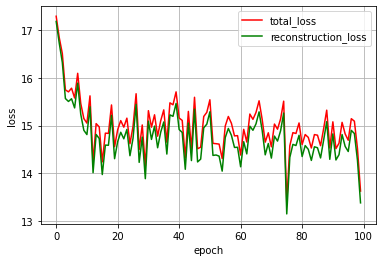

In [ ]:
from keras.callbacks import ReduceLROnPlateau

train_data = train_data.astype("float32") / 255
vae = VAE(encoder, decoder)                         # 初始化VAE类
vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))             # 指定优化器
reduce_lr = ReduceLROnPlateau(monitor='loss',patience=10,mode='auto')    # 学习率调整
vae.fit(train_data, epochs=100, batch_size=64, callbacks=[reduce_lr,SGDLearningRateTracker()])  # 回调函数为学习率调整方法和损失曲线绘制方法

## 用训练好的模型重构测试集中的10张图片并进行可视化

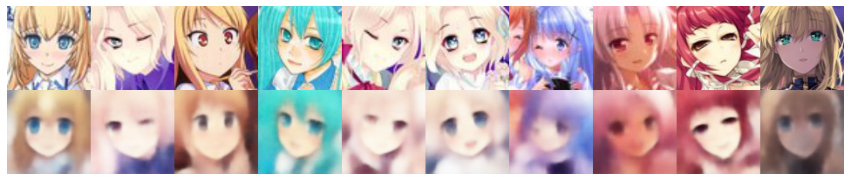

In [ ]:
def plot_latent2(test, encoder, decoder):
    n = 10       # 张数
    digit_size = 96  # 图像大小                        
    figsize = 15    
    # 用于显示的图像，总大小为（96*2,96*n），每张小图大小（96*96），上方为原图数据，下方为对应重构图像
    figure = np.zeros((digit_size * 2, digit_size * n,3))

    for i,x in enumerate(test[43:43+n]):
        x=x/255
        z=encoder(x.reshape(1,96,96,3))                # 获取其编码向量  
        x_decoded = decoder.predict(z)                # 通过对应编码向量进行图像重构 
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)  # 网络输出的形状为[None，96,96,3] 所以需要将其提取出来
        # 将原图数据写入数组前96行
        figure[
               0:96,
               i*digit_size: (i+1)*digit_size,
        ]=x                              
        # 重构图像写入数组后96行，与原图案列对应
        figure[
               96:,
               i*digit_size: (i+1)*digit_size,
        ] = digit                          

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    plt.axis('off')
    plt.imshow(figure)
    plt.show()


plot_latent2(test_data,encoder, decoder)


## 对测试数据集进行重构并保存图片用于后期计算IS


In [ ]:
del train_data
def evaluate(test_data, encoder, decoder):
  recon_test={}            # 用于保存的字典（piclkle保存字典）
  test=[]               # 用于存放图像数据的列表
  path="drive/My Drive/recon_test"  # 保存路径
  for i,x in enumerate(test_data):
    x=x/255

    # 重构图像
    z=encoder(x.reshape(1,96,96,3))
    x_decoded = decoder.predict(z)
    digit = x_decoded[0].reshape(1, 96, 96, 3)

    # 添入数组用于保存
    test.append(digit)

  # 将字典写入pickle文件
  recon_test['data']=test
  output=open(path,'wb')
  pickle.dump(recon_test,output)

evaluate(test_data, encoder, decoder)

2000 1


## 使用模型随机生成n*n张图像并进行可视化

由于所有分布逼近了标准正态分布，所以可直接由标准正态分布采样噪声生成图像，理论上可以生成出训练集中未出现过的图像

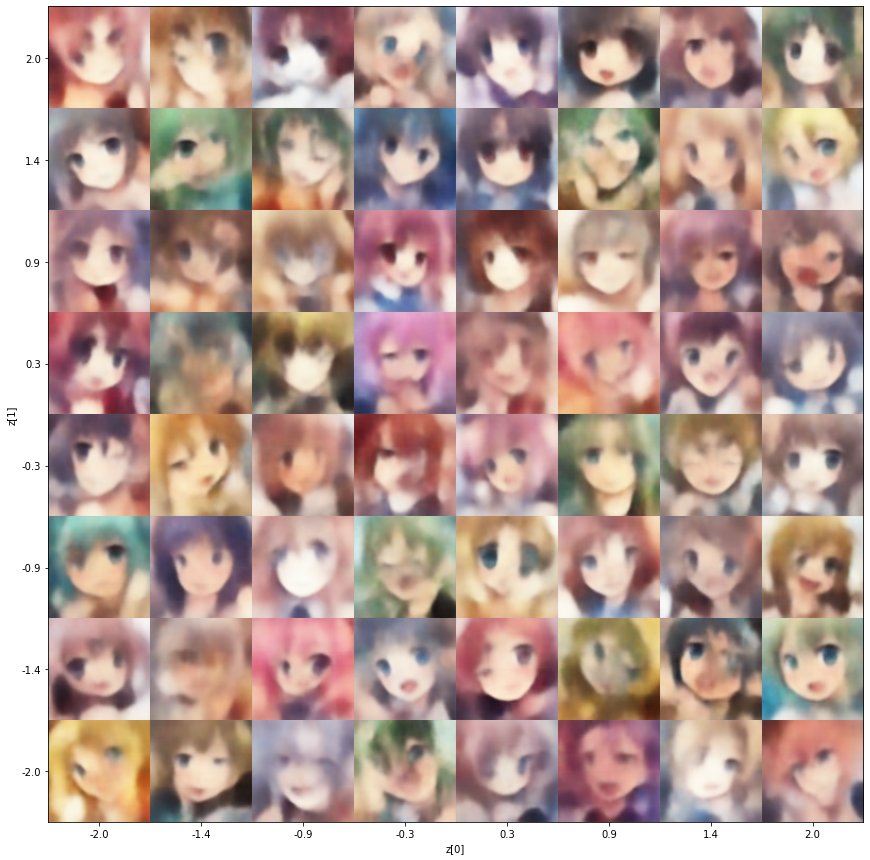

In [ ]:
import matplotlib.pyplot as plt

def plot_latent(encoder, decoder):
    n = 8           # 共生成n*n张图片
    digit_size = 96      # 单张图像大小
    scale = 2.0        # 单张图像下标，用于为最后展示的图像数组精确赋值
    figsize = 15 
    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            x_decoded = decoder.predict(np.random.normal(size=(1,latent_dim)))     # 输入为标准正态分布采样而得到的向量
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent(encoder, decoder)
